# Predicting the Past, United States Validation
## Total Mass Comparison

For this validation, there are 2 notebooks that reflect this work. This notebook (total-mass-validation.ipynb) and isotopic-mass-validation.ipynb 

This notebook includes comparisons between _CYCLUS_ output and UDB data for the United States from 1968 to 2013 for: 
 - Total spent fuel mass for varying refuel and cycle time

The UDB data is taken from UNF_ST&DARDS Unified Database and the Automatic Document Generator. 

The _CYCLUS_ data was generated by using published data of the commericial reactors that have operated in the United States. The _CYCLUS_ input file and simulation were generated in the original Predicting the Past, United States notebook. This notebook uses the SQL data file produced from the _CYCLUS_ simulation to do further analysis. 

** Import necessary libraries ** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipywidgets import *

import csv
import collections
import dateutil.parser as date
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import sys
import sqlite3 as lite
from matplotlib import cm
from pyne import nucname as nn
from IPython.display import Image, HTML, display
import seaborn as sns 
import udb_analysis as udb

sys.path.append('../../../scripts/')
import analysis as an

** Run UDB analysis ** 

In [2]:
spent_fuel_mass_cum, CURIE_isotope_cum_all, curie_isotope_list = udb.udb_analysis('SNF_nuclide_2020_07_01.dat')

** Plot of Cumulative mass of spent fuel against discharge year from CURIE data ** 

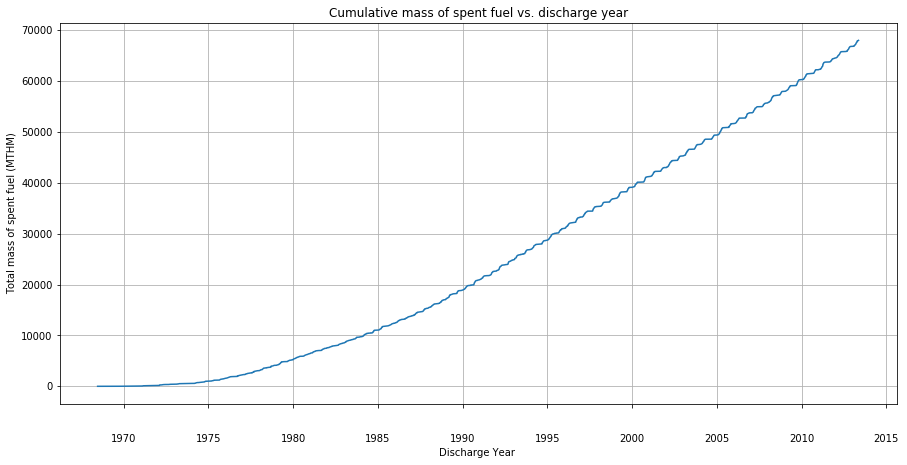

In [3]:
index = spent_fuel_mass_cum.index.values
data = spent_fuel_mass_cum.values
dts = pd.to_datetime(index)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data)
ax.grid()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ')
ax.set_ylabel('Total mass of spent fuel (MTHM)')
ax.set_title('Cumulative mass of spent fuel vs. discharge year')
plt.savefig('figures/cumulative_mass_spent_fuel.png', dpi=300)

## CYCLUS Data Analysis

** Setting up to query united_states.sqlite generated by Predicting the Past, United States Notebook ** 

Before this step, must download the output sqlite files from the fuel-cycles box: fuel-cycle/cyclus_output/predicting_the_past_validation and put into a directory named cyclus 

The input files that were used to generate the sqlite output files, were generated using ../united_states.ipynb where cycle time and refuel time were varied. 

|            Sqlite file name           | refuel time | cycle time |
|---------------------------------------|-------------|------------|
|      united_states_refueltime1        |      1      |     18     |
|      united_states_refueltime3        |      3      |     18     |
|      united_states_refueltime5        |      5      |     18     |
| united_states_refueltime1_cycletime13 |      1      |     13     |
| united_states_refueltime1_cycletime20 |      1      |     20     |
| united_states_refueltime1_cycletime24 |      1      |     24     |

In [8]:
cursor_refuel1 = an.cursor('cyclus/united_states_refueltime1.sqlite')
cursor_refuel3 = an.cursor('cyclus/united_states_refueltime3.sqlite')
cursor_refuel5 = an.cursor('cyclus/united_states_refueltime5.sqlite')
cursor_refuel1_cycle13 = an.cursor('cyclus/united_states_refueltime1_cycletime13.sqlite')
cursor_refuel1_cycle20 = an.cursor('cyclus/united_states_refueltime1_cycletime20.sqlite')
cursor_refuel1_cycle24 = an.cursor('cyclus/united_states_refueltime1_cycletime24.sqlite')

** Getting cumulative spent fuel produced ** 

In [1]:
def spent_fuel_produced(cur): 
    """ Find timeseries of mass of spent fuel output by reactors 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    timeseries list of spent fuel output by reactors
    """

    init_yr, init_month, duration, timestep = an.simulation_timesteps(cur)
    spent_fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                             'INNER JOIN resources '
                             'ON transactions.resourceid = resources.resourceid '
                             'WHERE Commodity = "spent_uox" '
                             'GROUP BY time ').fetchall()
    return an.timeseries_cum(spent_fuel,duration,True)

** Plots of Cumulative mass of spent fuel against discharge year from CYCLUS and CURIE data for varying refuel times and burn up** 

In [10]:
def get_spentfuel_cumplot(cur): 
    """ Gets list of cumulative mass of spent fuel for specified start to end year 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    returns a list of spent fuel data from start year to end year
    """

    start_year = 1968
    end_year = 2014
    start_index = (start_year - 1965) * 12
    end_index = (end_year - 1965) * 12
    dura = end_year - start_year
    init_yr, init_month, duration, timestep = an.simulation_timesteps(cur)
    
    timestep_range = timestep[start_index: end_index]
    full_range = spent_fuel_produced(cur)
    generated_range = full_range[start_index: end_index]
    
    return generated_range 

## Cumulative Spent Fuel (1968 - 2013) for CURIE and Cyclus on the same plot 

** Set up CYCLUS dataframe ** 

In [11]:
def get_cyclus_dataframe(cur,refueltime,cycletime):
    """ Puts Cyclus data into pandas dataframe for easier analysis
    
    Parameters 
    ----------
    cur: sqlite cursor 
    refueltime: int
    burnup: int 
    
    Returns 
    -------
    a pandas dataframe of dates and cyclus data 
    """
    
    generated_range = get_spentfuel_cumplot(cur)
    
    cyclus_dates = pd.date_range(start='1/1/1968', periods=552, freq='M')
    cyclus_data = pd.DataFrame({'discharge_date':cyclus_dates, ('total_mass_MTHM_cyclus_refueltime' + str(refueltime) + '_cycletime' + str(cycletime)): generated_range})
    cyclus_data = cyclus_data.set_index('discharge_date')
    cyclus_data.index.names = ['discharge_date']
    
    return cyclus_data 

cyclusdata_refuel1 = get_cyclus_dataframe(cursor_refuel1,1,18)
cyclusdata_refuel3 = get_cyclus_dataframe(cursor_refuel3,3,18)
cyclusdata_refuel5 = get_cyclus_dataframe(cursor_refuel5,5,18)
cyclus_data_refuel1_cycle13 = get_cyclus_dataframe(cursor_refuel1_cycle13,1,13)  
cyclus_data_refuel1_cycle20 = get_cyclus_dataframe(cursor_refuel1_cycle20,1,20) 
cyclus_data_refuel1_cycle24 = get_cyclus_dataframe(cursor_refuel1_cycle24,1,24)

** Set up Combined dataframe ** 

In [12]:
combined_data = spent_fuel_mass_cum.join(cyclusdata_refuel1, how='outer')
combined_data = combined_data.join(cyclusdata_refuel3, how='left')
combined_data = combined_data.join(cyclusdata_refuel5, how='left')
combined_data = combined_data.join(cyclus_data_refuel1_cycle13, how='left')
combined_data = combined_data.join(cyclus_data_refuel1_cycle20, how='left')
combined_data = combined_data.join(cyclus_data_refuel1_cycle24, how='left')

** Plot of UDB and CYCLUS Cumulative mass of spent fuel against discharge year ** 

In [36]:
def plot_UDB_cyclus(refuel_time_cycle_time):
    """ Plot timeseries of cumulative mass of spent fuel against discharge time
    
    Parameters 
    ----------
    refuel_time_cycle_time: list of lists of refuel and cycle time of plots to include
    
    Returns 
    -------
    returns a plot of the specified refuel and cycle time data
    
    """
    
    index = combined_data.index.values
    data = combined_data.values
    dts = pd.to_datetime(index)
    
    fig, ax = plt.subplots(figsize=(15,7))
    
    dict_combined_data = {}
    dict_combined_data[1] = [1,18]
    dict_combined_data[2] = [3,18]
    dict_combined_data[3] = [5,18]
    dict_combined_data[4] = [1,13]
    dict_combined_data[5] = [1,20]
    dict_combined_data[6] = [1,24]
    
    colors = ['steelblue','indianred','darkseagreen','coral','plum','darkseagreen','coral']
    
    key_list = [0]
    for x in refuel_time_cycle_time: 
        for key in dict_combined_data:
            list_in = dict_combined_data[key]
            if list_in == x:
                key_list.append(key)
    for x in range(0,len(key_list)):
        num = key_list[x]
        if num == 0: 
            ax.scatter(dts, data[:,num], color = colors[num], label='UDB data', marker = ".", s = 100)
        else: 
            ax.scatter(dts, data[:,num], color = colors[num], label='CYCLUS data: refuel time, cycle time = %s ' %dict_combined_data[num], marker = ".", s = 100)
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18)
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
    ax.set_ylabel('Total mass of spent fuel (MTHM)', fontsize=18)
    ax.set_title('Cumulative mass of spent fuel vs. discharge year', fontsize=22)
    if len(key_list) == 2: 
        plt.savefig('figures/cumulative_mass_udb_cyclus.png', bbox_inches="tight")
    elif len(key_list) == 4: 
        plt.savefig('figures/cumulative_mass_udb_cyclus_refueltime.png', bbox_inches="tight")
    elif len(key_list) == 5: 
        plt.savefig('figures/cumulative_mass_udb_cyclus_cycletime.png', bbox_inches="tight")
    return 

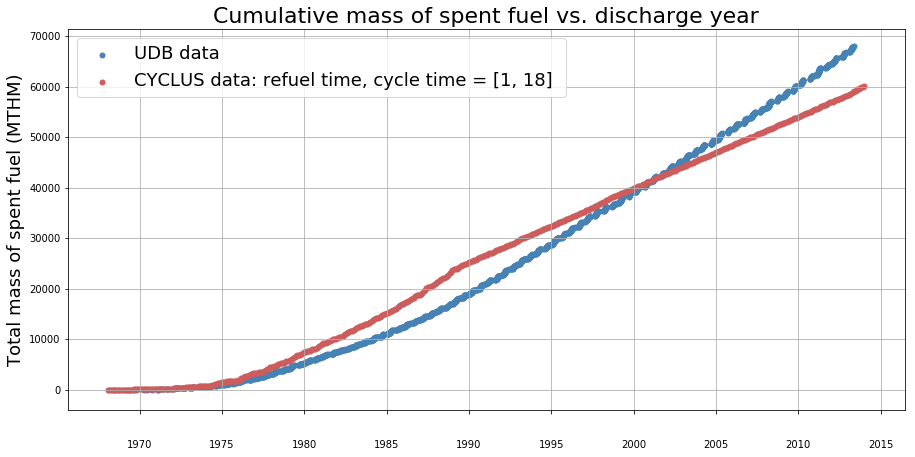

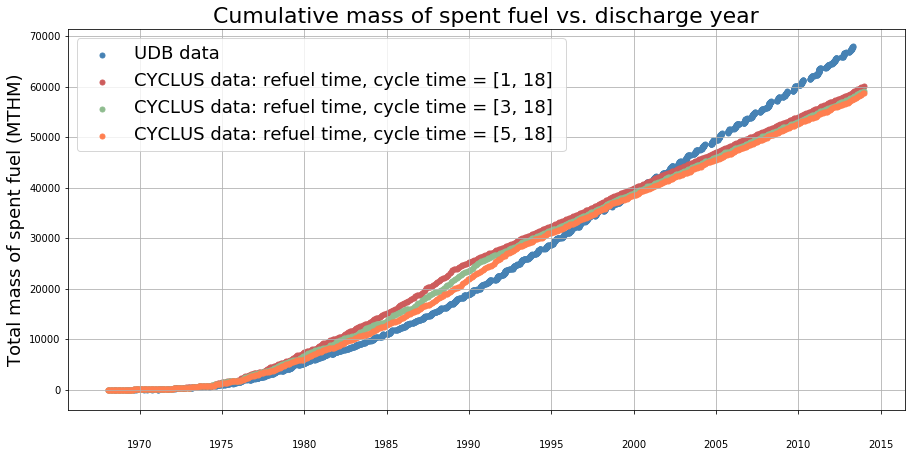

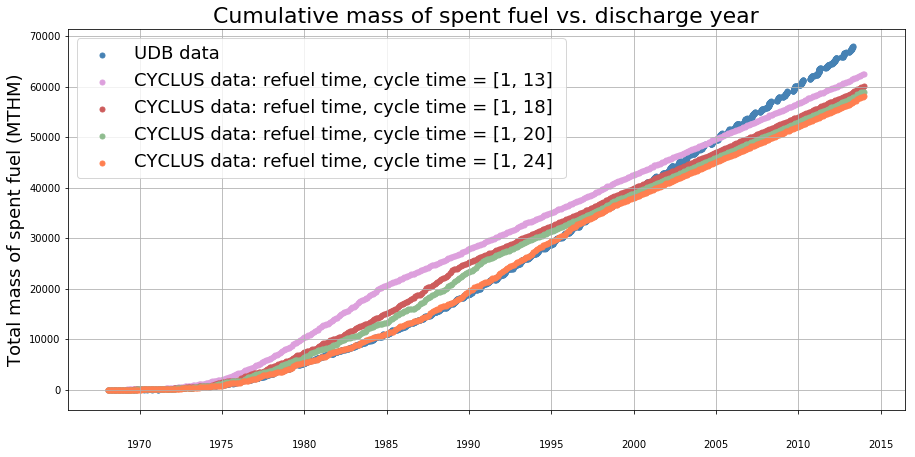

In [37]:
plot_UDB_cyclus([[1,18]])
plot_UDB_cyclus([[1,18],[3,18],[5,18]])
plot_UDB_cyclus([[1,13],[1,18],[1,20],[1,24]])